## Import and Configure Everything We Need

In [7]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

__author__ = 'Marcel Baltruschat'
__copyright__ = 'Copyright © 2020-2023'
__license__ = 'MIT'
__version__ = '1.1.0'

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation
sns.set(palette='bright')  # Set bright style for Seaborn
PandasTools.RenderImagesInAllDataFrames()  # Render mol images

# In many cases NaN
not_used_desc = [
    'HeavyAtomMolWt',
    "ExactMolWt",
    "FpDensityMorgan1",
    "FpDensityMorgan2",
    "FpDensityMorgan3",
    'MaxPartialCharge', 
    'MinPartialCharge',
    'MaxAbsPartialCharge', 
    'MinAbsPartialCharge', 
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',
]

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])
print(f'Number of descriptors used: {len(desc_calc.descriptorNames)}/{len(Descriptors.descList)}')

Number of descriptors used: 194/211


## Defining Cross-Validation Class

In [2]:
"""
Copyright © 2019 Marcel Baltruschat

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files 
(the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do 
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

Source: https://github.com/czodrowskilab/gafp/tree/master/fp
"""
class CVRegressor:
    """
    Regressor that predicts based on predictions of k models from k-fold CV.
    Accepts any Scikit-learn-like regressor as base regressor. It trains k models
    by doing k-fold CV and stores the individual models. Predictions
    on new samples are done by calculating mean predictions from all models.
    
    Parameters
    ----------
    est : Any
        Scikit-learn (-like) regressor object. Must contain .fit() and .predict() methods.
    params : Dict[str, Any]
        Regressor parameters
    n_folds : int
        Number of folds for k-fold
    shuffle : bool
        Shuffling of data for CV
    """
    __slots__ = ('est', 'params', 'models', 'n_folds', 'shuffle', 'cv_scores')

    def __init__(self, est: Any, params: Dict[str, Any], n_folds: int = 5, shuffle: bool = True):
        self.est = est
        self.params = params
        self.models = []
        self.n_folds = n_folds
        self.shuffle = shuffle
        self.cv_scores = ddict(list)

    def fit(self, x_data: np.ndarray, y_data: np.ndarray, scoring_funcs: List=(), random_state: int=None) -> None:
        """
        Build a regressor consisting of k-models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Training data
        y_data : numpy.ndarray
            Target values
        scoring_funcs : list
            List of scoring functions to use for evaluating cross-validation results
        random_state : int
            Integer to use for seeding the k-fold split
        """

        kf = KFold(n_splits=self.n_folds, shuffle=self.shuffle, random_state=random_state)
        kf = kf.split(X=x_data, y=y_data)

        # Fit k models and store them
        for train_index, test_index in kf:
            est_tmp = self.est(**self.params)
            est_tmp.fit(x_data[train_index], y_data[train_index])
            if scoring_funcs:
                test_pred = est_tmp.predict(x_data[test_index])
                for sf in scoring_funcs:
                    self.cv_scores[str(sf).split(' ')[1]].append(sf(y_data[test_index], test_pred))
            self.models.append(est_tmp)

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        """
        Predict using prediction mean from k models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Samples to predict
        
        Returns
        -------
        numpy.ndarray
            Predicted values
        """

        return np.mean([m.predict(x_data) for m in self.models], axis=0)

## Defining Helpful Functions

In [9]:
def rmse(y_true, y_pred):
    """Helper function"""
    return mean_squared_error(y_true, y_pred, squared=False)

def calc_stats_str(pka1, pka2):
    """Calculates R², MAE and RMSE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {r2_score(pka1, pka2):.3f}\n' \
           f'MAE: {mean_absolute_error(pka1, pka2):.3f}\n' \
           f'RMSE: {rmse(pka1, pka2):.3f}'

def train_cv_model(est_cls, x_data, y_data, params, random_state,
                   cv=5, shuffle=True, scaled=False, scoring_funcs=(mean_absolute_error, rmse, r2_score)):
    """Scales the training data if wanted and trains a cross-validated model"""
    scaler = None
    if scaled:
        scaler = StandardScaler()
        x_data = scaler.fit_transform(x_data)
    cvr = CVRegressor(est=est_cls, params=params, n_folds=cv, shuffle=shuffle)
    cvr.fit(x_data, y_data, scoring_funcs=scoring_funcs, random_state=random_state)
    return cvr, scaler

def calc_x_data(mols):
    """Calculates descriptors and fingerprints for an iterable of RDKit molecules"""
    descs = []  # 196/200 RDKit descriptors
    fmorgan3 = []  # 4096 bit
    for mol in mols:
        descs.append(desc_calc.CalcDescriptors(mol))
        fmorgan3.append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4096, useFeatures=True))
    descs = np.array(descs)
    fmorgan3 = np.array(fmorgan3)
    return descs, fmorgan3, np.concatenate([descs, fmorgan3], axis=1)

---
## Loading Precombined Dataset

[09:38:27] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 7 ignored


Initial: 5921


/home/u93099@sp.se/miniconda3/envs/pka/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ROMol
ID,,,,,,
273537,7.460,8.200,8,basic,['chembl25'],
7175,4.200,3.940,7,basic,['datawarrior'],

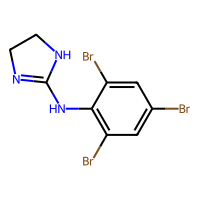
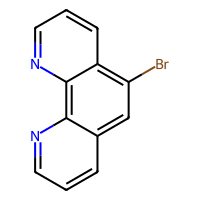

In [3]:
sdf_path = './datasets/combined_training_datasets_unique_no_oe.sdf'
all_df = PandasTools.LoadSDF(sdf_path).astype(dict(pKa=float, 
                                                   marvin_atom=int, 
                                                   marvin_pKa=float), 
                                              copy=False).set_index('ID', verify_integrity=True)
print(f'Initial: {len(all_df)}')
all_df.head(2)

## Show p<i>K</i><sub>a</sub> Distribution

In [4]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])

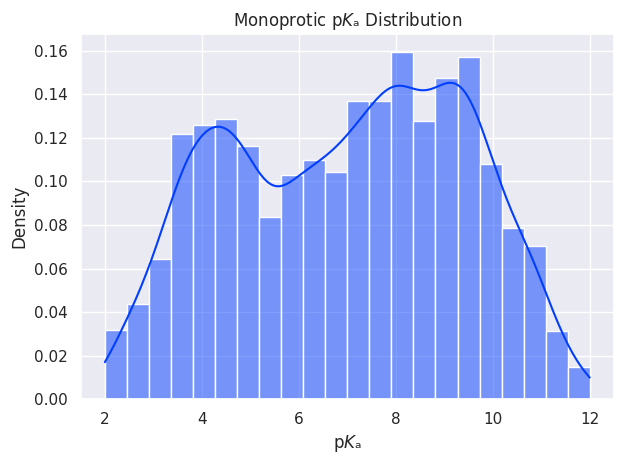

In [5]:
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(all_df.pKa, kde=True, stat='density')
else:
    sns.distplot(all_df.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution')
plt.tight_layout()
plt.show()

## Calculating Descriptors and Fingerprints
- Selected RDKit descriptors (see first notebook cell)
- Morgan FP with radius=3 and useFeatures=True (FMorgan3)

In [10]:
#all_df['Morgan_Fingerprint'] = df['smiles'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=2048))

descs, fmorgan3, descs_fmorgan3 = calc_x_data(all_df.ROMol)

---
## Training Random Forest, Support Vector Machine (two configurations) and Multilayer Perceptron (three configurations)
#### Using the following training sets with 5-fold cross-validation (shuffled)
1. RDKit descriptor set
2. FMorgan3
3. RDKit descriptor set + FMorgan3
4. RDKit descriptor set (standard scaled)
5. FMorgan3 (standard scaled)
6. RDKit descriptor set + FMorgan3 (standard scaled)

### Prepare for Training

In [11]:
seed = 24

est_jobs = 48
verbose = False

y_train = all_df.pKa.values
desc_sets = list(zip([descs, fmorgan3, descs_fmorgan3] * 2, 
                     [False] * 3 + [True] * 3, 
                     ['Desc', 'FMorgan3', 'Desc_FMorgan3', 'Desc_scaled', 'FMorgan3_scaled', 'Desc_FMorgan3_scaled']))

models = ddict(odict)  # estimator => training set => [model, scaler]

def train_all_sets(est_cls, params, name):
    for x_data, scaled, set_name in desc_sets:
        models[name][set_name] = train_cv_model(est_cls, x_data, y_train, params, seed, scaled=scaled)

In [12]:
def generate_score_board(name):
    print(f'{name} CV Scores:')
    for ts, (m, s) in models[name].items():
        print(f'\t{ts}')
        for k, v in m.cv_scores.items():
            print(f'\t\t- {k}: {np.mean(v):.3f} ± {np.std(v):.3f}')

---
### RandomForest (n_estimators=1000)

In [13]:
est_cls = RandomForestRegressor
rf_params = dict(n_estimators=1000, n_jobs=est_jobs, verbose=verbose, random_state=seed)
name = 'RandomForest (n_estimators=1000)'

train_all_sets(est_cls, rf_params, name)

#### CV Scores

In [11]:
generate_score_board(name)

RandomForest (n_estimators=1000) CV Scores:
	Desc
		- mean_absolute_error: 0.718 ± 0.022
		- rmse: 1.077 ± 0.021
		- r2_score: 0.804 ± 0.011
	FMorgan3
		- mean_absolute_error: 0.708 ± 0.021
		- rmse: 1.094 ± 0.030
		- r2_score: 0.797 ± 0.008
	Desc_FMorgan3
		- mean_absolute_error: 0.683 ± 0.017
		- rmse: 1.032 ± 0.013
		- r2_score: 0.820 ± 0.005
	Desc_scaled
		- mean_absolute_error: 0.718 ± 0.022
		- rmse: 1.077 ± 0.021
		- r2_score: 0.804 ± 0.011
	FMorgan3_scaled
		- mean_absolute_error: 0.708 ± 0.021
		- rmse: 1.094 ± 0.030
		- r2_score: 0.797 ± 0.008
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.682 ± 0.017
		- rmse: 1.032 ± 0.014
		- r2_score: 0.820 ± 0.005


---
### SupportVectorMachine (gamma='scale')

In [12]:
est_cls = SVR
svr_params = dict(cache_size=4096, verbose=verbose)
name = 'SupportVectorMachine (gamma="scale")'

train_all_sets(est_cls, svr_params, name)

#### CV Scores

In [13]:
generate_score_board(name)

SupportVectorMachine (gamma="scale") CV Scores:
	Desc
		- mean_absolute_error: 2.100 ± 0.037
		- rmse: 2.436 ± 0.035
		- r2_score: -0.004 ± 0.004
	FMorgan3
		- mean_absolute_error: 0.851 ± 0.025
		- rmse: 1.240 ± 0.035
		- r2_score: 0.740 ± 0.012
	Desc_FMorgan3
		- mean_absolute_error: 2.100 ± 0.037
		- rmse: 2.436 ± 0.035
		- r2_score: -0.004 ± 0.004
	Desc_scaled
		- mean_absolute_error: 0.876 ± 0.033
		- rmse: 1.282 ± 0.047
		- r2_score: 0.722 ± 0.015
	FMorgan3_scaled
		- mean_absolute_error: 1.090 ± 0.034
		- rmse: 1.466 ± 0.041
		- r2_score: 0.637 ± 0.014
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.020 ± 0.037
		- rmse: 1.400 ± 0.047
		- r2_score: 0.668 ± 0.016


---
### SupportVectorMachine (gamma='auto')

In [14]:
est_cls = SVR
svr_params = dict(cache_size=4096, verbose=verbose, gamma='auto')
name = 'SupportVectorMachine (gamma="auto")'

train_all_sets(est_cls, svr_params, name)

#### CV Scores

In [15]:
generate_score_board(name)

SupportVectorMachine (gamma="auto") CV Scores:
	Desc
		- mean_absolute_error: 2.016 ± 0.042
		- rmse: 2.362 ± 0.039
		- r2_score: 0.057 ± 0.009
	FMorgan3
		- mean_absolute_error: 1.612 ± 0.031
		- rmse: 1.926 ± 0.033
		- r2_score: 0.373 ± 0.007
	Desc_FMorgan3
		- mean_absolute_error: 1.642 ± 0.061
		- rmse: 2.052 ± 0.060
		- r2_score: 0.288 ± 0.027
	Desc_scaled
		- mean_absolute_error: 0.882 ± 0.034
		- rmse: 1.289 ± 0.048
		- r2_score: 0.719 ± 0.016
	FMorgan3_scaled
		- mean_absolute_error: 1.090 ± 0.034
		- rmse: 1.465 ± 0.041
		- r2_score: 0.637 ± 0.014
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.019 ± 0.037
		- rmse: 1.399 ± 0.047
		- r2_score: 0.669 ± 0.016


---
### Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500))

In [16]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(500, 500), verbose=verbose, random_state=seed)
name = 'Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [17]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500)) CV Scores:
	Desc
		- mean_absolute_error: 1271696.821 ± 1408226.203
		- rmse: 29108134.111 ± 32735677.639
		- r2_score: -325252605213428.125 ± 541181737644747.750
	FMorgan3
		- mean_absolute_error: 0.866 ± 0.025
		- rmse: 1.270 ± 0.047
		- r2_score: 0.727 ± 0.019
	Desc_FMorgan3
		- mean_absolute_error: 545089.024 ± 1060546.904
		- rmse: 13064016.783 ± 25482740.053
		- r2_score: -135006584826116.750 ± 269948690269777.125
	Desc_scaled
		- mean_absolute_error: 0.719 ± 0.036
		- rmse: 1.101 ± 0.070
		- r2_score: 0.794 ± 0.027
	FMorgan3_scaled
		- mean_absolute_error: 1.037 ± 0.045
		- rmse: 1.457 ± 0.057
		- r2_score: 0.640 ± 0.024
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.980 ± 0.027
		- rmse: 1.396 ± 0.039
		- r2_score: 0.670 ± 0.018


---
### Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500))

In [18]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(500, 500), verbose=verbose, random_state=seed, early_stopping=True)
name = 'Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [19]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500)) CV Scores:
	Desc
		- mean_absolute_error: 44870.635 ± 79664.054
		- rmse: 1033703.699 ± 1838252.342
		- r2_score: -756612171338.868 ± 1503016957841.996
	FMorgan3
		- mean_absolute_error: 0.894 ± 0.024
		- rmse: 1.297 ± 0.040
		- r2_score: 0.715 ± 0.016
	Desc_FMorgan3
		- mean_absolute_error: 31056.118 ± 37579.105
		- rmse: 732296.915 ± 892324.002
		- r2_score: -221848262737.899 ± 292522891440.588
	Desc_scaled
		- mean_absolute_error: 0.764 ± 0.019
		- rmse: 1.139 ± 0.045
		- r2_score: 0.780 ± 0.019
	FMorgan3_scaled
		- mean_absolute_error: 1.031 ± 0.037
		- rmse: 1.447 ± 0.057
		- r2_score: 0.645 ± 0.026
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.982 ± 0.030
		- rmse: 1.396 ± 0.041
		- r2_score: 0.670 ± 0.017


---
### Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250))

In [20]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(250, 250, 250), verbose=verbose, random_state=seed, early_stopping=True)
name = 'Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [21]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250)) CV Scores:
	Desc
		- mean_absolute_error: 7762.670 ± 10437.941
		- rmse: 183574.503 ± 250768.790
		- r2_score: -15964329607.095 ± 27326138165.481
	FMorgan3
		- mean_absolute_error: 0.869 ± 0.023
		- rmse: 1.265 ± 0.039
		- r2_score: 0.729 ± 0.016
	Desc_FMorgan3
		- mean_absolute_error: 11897.419 ± 17932.190
		- rmse: 249024.111 ± 375387.533
		- r2_score: -34288201298.110 ± 65184036927.772
	Desc_scaled
		- mean_absolute_error: 0.777 ± 0.030
		- rmse: 1.171 ± 0.081
		- r2_score: 0.767 ± 0.034
	FMorgan3_scaled
		- mean_absolute_error: 1.026 ± 0.038
		- rmse: 1.455 ± 0.053
		- r2_score: 0.642 ± 0.022
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.973 ± 0.028
		- rmse: 1.381 ± 0.045
		- r2_score: 0.677 ± 0.019


---
### XGradientBoost

In [22]:
est_cls = xgb.XGBRegressor
xgb_params = dict(verbosity=2 if verbose else 0, random_state=seed, n_jobs=est_jobs)
name = 'XGradientBoost'

train_all_sets(est_cls, xgb_params, name)

#### CV Scores

In [23]:
generate_score_board(name)

XGradientBoost CV Scores:
	Desc
		- mean_absolute_error: 0.754 ± 0.021
		- rmse: 1.106 ± 0.025
		- r2_score: 0.793 ± 0.010
	FMorgan3
		- mean_absolute_error: 0.836 ± 0.024
		- rmse: 1.185 ± 0.034
		- r2_score: 0.763 ± 0.011
	Desc_FMorgan3
		- mean_absolute_error: 0.767 ± 0.012
		- rmse: 1.110 ± 0.020
		- r2_score: 0.792 ± 0.009
	Desc_scaled
		- mean_absolute_error: 0.757 ± 0.025
		- rmse: 1.111 ± 0.027
		- r2_score: 0.791 ± 0.010
	FMorgan3_scaled
		- mean_absolute_error: 0.836 ± 0.024
		- rmse: 1.185 ± 0.034
		- r2_score: 0.763 ± 0.011
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.763 ± 0.015
		- rmse: 1.109 ± 0.020
		- r2_score: 0.792 ± 0.009


---
## Predicting external testsets

In [24]:
novartis_testset = PandasTools.LoadSDF('datasets/novartis_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
avlilumove_testset = PandasTools.LoadSDF('datasets/AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
len(novartis_testset), len(avlilumove_testset)

(280, 123)

#### Calculating descriptors

In [25]:
descs_nov, fmorgan3_nov, descs_fmorgan3_nov = calc_x_data(novartis_testset.ROMol)
descs_avl, fmorgan3_avl, descs_fmorgan3_avl = calc_x_data(avlilumove_testset.ROMol)

#### Predicting with all models

In [26]:
def test_all_models(desc, fp, both, true_vals):
    res = ddict(list)
    for conf, desc_set in models.items():
        for ts, (m, s) in desc_set.items():
            
            x_test = both if ts.startswith('Desc_FMorgan3') else fp if ts.startswith('FMorgan3') else desc
            if s:
                x_test = s.transform(x_test)
            pred = m.predict(x_test)
            res['Model'].append(conf)
            res['Trainset'].append(ts)
            res['MAE'].append(mean_absolute_error(true_vals, pred))
            res['RMSE'].append(rmse(true_vals, pred))
            res['R2'].append(r2_score(true_vals, pred))
    return pd.DataFrame(res)

In [27]:
res_df_nov = test_all_models(descs_nov, fmorgan3_nov, descs_fmorgan3_nov, novartis_testset.pKa)

In [28]:
res_df_nov

,Model,Trainset,MAE,RMSE,R2
0,RandomForest (n_estimators=1000),Desc,1.261,1.609,0.512
1,RandomForest (n_estimators=1000),FMorgan3,1.148,1.513,0.569
2,RandomForest (n_estimators=1000),Desc_FMorgan3,1.199,1.532,0.557
3,RandomForest (n_estimators=1000),Desc_scaled,1.261,1.609,0.512
4,RandomForest (n_estimators=1000),FMorgan3_scaled,1.148,1.513,0.569
5,RandomForest (n_estimators=1000),Desc_FMorgan3_scaled,1.199,1.532,0.557
6,"SupportVectorMachine (gamma=""scale"")",Desc,2.177,2.451,-0.132
7,"SupportVectorMachine (gamma=""scale"")",FMorgan3,1.423,1.732,0.435
8,"SupportVectorMachine (gamma=""scale"")",Desc_FMorgan3,2.177,2.451,-0.132
9,"SupportVectorMachine (gamma=""scale"")",Desc_scaled,1.381,1.733,0.434


In [29]:
res_df_avl = test_all_models(descs_avl, fmorgan3_avl, descs_fmorgan3_avl, avlilumove_testset.pKa)

In [30]:
res_df_avl

,Model,Trainset,MAE,RMSE,R2
0,RandomForest (n_estimators=1000),Desc,0.683,0.973,0.830
1,RandomForest (n_estimators=1000),FMorgan3,0.532,0.786,0.889
2,RandomForest (n_estimators=1000),Desc_FMorgan3,0.627,0.884,0.860
3,RandomForest (n_estimators=1000),Desc_scaled,0.685,0.974,0.830
4,RandomForest (n_estimators=1000),FMorgan3_scaled,0.532,0.786,0.889
5,RandomForest (n_estimators=1000),Desc_FMorgan3_scaled,0.625,0.881,0.861
6,"SupportVectorMachine (gamma=""scale"")",Desc,2.180,2.441,-0.070
7,"SupportVectorMachine (gamma=""scale"")",FMorgan3,0.688,0.981,0.827
8,"SupportVectorMachine (gamma=""scale"")",Desc_FMorgan3,2.180,2.441,-0.070
9,"SupportVectorMachine (gamma=""scale"")",Desc_scaled,0.771,1.057,0.799
